In [32]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from matplotlib import rcParams
from collections import defaultdict, Counter
from konlpy.tag import Okt
from datetime import datetime
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
# 게시글에서 특정 키워드(예: 정치인, 정책)의 언급 빈도(언급량)를 추출하여 '버즈 차트'를 생성

In [34]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제20대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_20/팍스넷_20대_대선_테마주_크롤링_20250627.csv"
NAVER_PATH = "../01_데이터수집/비정형데이터/stock_community/output/csv/제20대_대선_테마주/"

FIXED_START = datetime(2022, 2, 5)
FIXED_END = datetime(2022, 3, 16)

In [35]:
# ───────────── 데이터 로딩 ─────────────

####################### 팍스넷 데이터 ##################################
paxnet_df = pd.read_csv(PAXNET_PATH)
paxnet_df["날짜"] = pd.to_datetime(paxnet_df["날짜"])
#####################################################################



####################### 네이버 종토방 데이터 #############################
csv_files = [f for f in os.listdir(NAVER_PATH) if f.endswith(".csv")]   # 경로 내 csv 파일 목록 가져오기
dataframes = [] # concat 저장용

# 각 CSV 파일 읽어서 리스트에 추가
for file in csv_files:
    file_path = os.path.join(NAVER_PATH, file)
    try:
        df = pd.read_csv(file_path)
        df['filename'] = file  # 어떤 파일에서 왔는지 표시
        dataframes.append(df)
    except Exception as e:
        print(f"파일 읽기 오류: {file_path} → {e}")

naver_df = pd.concat(dataframes, ignore_index=True) # concat
naver_df['article_date'] = pd.to_datetime(naver_df['article_date'])
#####################################################################

okt = Okt()  # 형태소 분석기 인스턴스 생성

In [36]:
# ───────────── 데이터 전처리 ─────────────
naver_selected_df = naver_df[["stock_name", "article_date", "article_title", "article_content"]].copy()
naver_selected_df.rename(columns={
    "stock_name": "종목명",
    "article_date": "날짜",
    "article_title": "제목",
    "article_content": "내용"
}, inplace=True)

paxnet_selected_df = paxnet_df[['종목명', '날짜', '제목', '내용']].copy()

stock_df = pd.concat([naver_selected_df, paxnet_selected_df], ignore_index=True)    # 데이터 병합
stock_df.sort_values(by='날짜', inplace=True)   # datetime 순서로 정렬

In [37]:
# ───────────── 후보별 테마주 데이터 분리 ─────────────

yoon_keywords = ["NE능률", "덕성", "서연", "삼부토건", "노루홀딩스", "신원종합개발"]     # 윤석열 후보 테마주
lee_keywords = ["코나아이", "웹케시", "상지건설", "오리엔트바이오", "포바이포", "이스타코", "일성건설"]     # 이재명 후보 테마주

# 윤석열 후보 테마주
yoon_df = stock_df[stock_df["종목명"].isin(yoon_keywords)].copy()
yoon_df["후보"] = "윤석열"

# 이재명 후보 테마주
lee_df = stock_df[stock_df["종목명"].isin(lee_keywords)].copy()
lee_df["후보"] = "이재명"

In [38]:
lee_df

,종목명,날짜,제목,내용,후보
4216,일성건설,2022-02-05,일성 건설 이름부터 이상했다. 찢 ㅈ ㅐ 명 ㅇ ㅣ 김 일성,"찬양 하는것 같았ㄷ ㅏ. 구 ㄷ ㅣ,.. ㄴ ㅇ ㅉㅏ ㄴ ㅑ? ㅜ 과 사 ㄷ 구속 ...",이재명
4217,일성건설,2022-02-05,이재명 표정이 어두운 이유가,곽이 잡혀서였군 공범일텐데 ㅎㅎ,이재명
4218,일성건설,2022-02-05,미담 제조기 찢!,경기도 공무원들 시켜서 찢죄명이 친인척들 명절 선물들을 국민세금으로 구매해서 나눠줬...,이재명
4215,일성건설,2022-02-05,"이명박 정부 부정 부패 일지 5탄 (2011년에만 무려 417가지) ,뜨거운 화재(...",- 2011년 107. 독립성 요구되는 감사원장에 MB 측근 인사 정동기 내정 .....,이재명
4214,일성건설,2022-02-05,(속보) 성남FC 후원했다더니 성남시로 10억 후원한 네이버,따끈따끈 뉴스~!!! 성남FC 특검 가나요~~ http://naver.me/Fhys...,이재명
...,...,...,...,...,...
26097,코나아이,2022-03-16,내가 얼마나물렸냐면,상한가 박아도 손실임 ㅡㅡ,이재명
26098,코나아이,2022-03-16,주가 올라도,왜이리 우울허냐.....이제 파란게 더 악숙해진듯....쩝 짜증만 늘어나네 니미럴,이재명
26099,코나아이,2022-03-16,코나아이 유?보고 투자해라 ㅡㅡ,ㅂ ㅂ 들,이재명
24771,상지건설,2022-03-16,30 억 벌었다는데도,소식이 없네,이재명


In [39]:
# ─────────────────────────────────────────────
# MyKeywordExtractor: 형태소 + BERT 기반 키워드 추출기
# ─────────────────────────────────────────────
class MyKeywordExtractor:
    def __init__(self, model_name="klue/bert-base", device=None, min_freq=2):
        self.okt = Okt()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.device = device or ("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        self.min_freq = min_freq

    def get_cls_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] 벡터
        return cls_embedding.cpu().numpy()

    def get_token_embedding(self, word):
        inputs = self.tokenizer(word, return_tensors="pt", truncation=True, max_length=20)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        token_embeds = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        return token_embeds.cpu().numpy()

    def extract_keywords(self, text_list, top_k=15):
        noun_counter = Counter()
        for text in text_list:
            if not isinstance(text, str): continue
            nouns = self.okt.nouns(text)
            noun_counter.update(nouns)

        candidates = [word for word, count in noun_counter.items() if count >= self.min_freq]
        if not candidates:
            return []

        full_text = " ".join(text_list)
        doc_embedding = self.get_cls_embedding(full_text)

        scored_words = []
        for word in candidates:
            token_embed = self.get_token_embedding(word)
            similarity = cosine_similarity(doc_embedding, token_embed)[0][0]
            scored_words.append((word, similarity))

        scored_words.sort(key=lambda x: x[1], reverse=True)
        return [word for word, _ in scored_words[:top_k]]

# ─────────────────────────────────────────────
# 후보·종목별 키워드를 포함한 데이터프레임 생성
# ─────────────────────────────────────────────
def make_keyword(
    후보명,
    df,
    종목명="종목명",
    제목="제목",
    내용="내용",
    top_k=15,
    min_freq=2
):
    extractor = MyKeywordExtractor(min_freq=min_freq)
    result_rows = []

    grouped_by_stock = df.groupby(종목명)

    for 종목, group in tqdm(grouped_by_stock, desc=f"{후보명} 종목별 키워드 추출"):
        title_list = group[제목].dropna().tolist()
        content_list = group[내용].dropna().tolist()
        text_list = title_list + content_list

        if not text_list:
            continue

        # 형태소 분석 후 빈도 계산
        noun_counter = Counter()
        for text in text_list:
            if not isinstance(text, str): continue
            nouns = extractor.okt.nouns(text)
            noun_counter.update(nouns)

        # BERT 기반으로 의미 있는 키워드만 선별
        candidates = {noun: count for noun, count in noun_counter.items() if count >= min_freq}
        if not candidates:
            continue

        doc_embedding = extractor.get_cls_embedding(" ".join(text_list))
        scored_keywords = []

        for word, count in candidates.items():
            token_embed = extractor.get_token_embedding(word)
            similarity = cosine_similarity(doc_embedding, token_embed)[0][0]
            scored_keywords.append((word, similarity, count))

        # 상위 top_k 개수만 선택
        scored_keywords.sort(key=lambda x: x[1], reverse=True)
        top_keywords = scored_keywords[:top_k]

        # 형태: {'키워드': 등장횟수}
        keyword_dict = {word: freq for word, _, freq in top_keywords}

        result_rows.append({
            "후보": 후보명,
            "종목명": 종목,
            "키워드": keyword_dict
        })

    return pd.DataFrame(result_rows)

In [40]:
# 후보별로 따로 실행
yoon_keywords_df = make_keyword("윤석열", yoon_df, top_k=50, min_freq=2)
lee_keywords_df = make_keyword("이재명", lee_df, top_k=50, min_freq=2)

이재명 종목별 키워드 추출: 100%|██████████| 6/6 [01:43<00:00, 17.26s/it]


In [41]:
# 통합
final_df = pd.concat([yoon_keywords_df, lee_keywords_df], ignore_index=True)

os.makedirs("data", exist_ok=True)
final_df.to_csv("data/제20대_대선후보_종목별_키워드.csv", index=False)

In [42]:
final_df

,후보,종목명,키워드
0,윤석열,NE능률,"{'좌빠들': 2, '주가조작': 352, '체포하라': 2, '엄벌': 2, '윤..."
1,윤석열,노루홀딩스,"{'김건희': 8, '윤석열': 12, '죄명': 3, '관련': 4, '녹취록':..."
2,윤석열,덕성,"{'똘마니들': 2, '윤핵관들': 8, '횡설수설': 4, '진중권': 9, '독..."
3,윤석열,삼부토건,"{'거래량봐': 2, '악재떳': 2, '물량뺏기': 2, '급락': 24, '급등..."
4,윤석열,서연,"{'똘마니들': 6, '이명박': 29, '종북': 8, '이중과세': 2, '따라..."
5,윤석열,신원종합개발,"{'급락': 10, '급등': 23, '윤핵관들': 2, '공매도': 15, '관망..."
6,이재명,상지건설,"{'급락': 2, '꼭짓점': 2, '하락': 6, '단행': 2, '주식': 11..."
7,이재명,오리엔트바이오,"{'발주': 2, '무식': 4, '종목': 18, '급등': 5, '압독적': 2..."
8,이재명,웹케시,"{'지배구조': 3, '청원': 2, '금지': 2, '주식': 11, '배당': ..."
9,이재명,이스타코,"{'안희정': 2, '요약': 2, '이재명': 139, '공매도': 5, '폐지'..."


In [43]:
class BuzzChartGenerator:
    def __init__(self, keyword_df: pd.DataFrame, article_df: pd.DataFrame, price_dir: str):
        self.keyword_df = keyword_df
        self.article_df = article_df
        self.price_dir = price_dir

    def extract_keywords_by_date(self, stock_name: str, start_date=None, end_date=None):
        post_df = self.article_df[self.article_df["종목명"] == stock_name].copy()
        keywords_row = self.keyword_df[self.keyword_df["종목명"] == stock_name]
        if keywords_row.empty:
            raise ValueError(f"{stock_name}의 키워드가 keyword_df에 없습니다.")

        raw_kw = keywords_row["키워드"].values[0]
        keyword_dict = raw_kw if isinstance(raw_kw, dict) else eval(raw_kw)
        keywords = list(keyword_dict.keys())

        keyword_freq_by_date = defaultdict(lambda: defaultdict(int))

        for _, row in post_df.iterrows():
            date = pd.to_datetime(row["날짜"]).date()
            if start_date and date < start_date.date():
                continue
            if end_date and date > end_date.date():
                continue

            text = f"{row['제목']} {row['내용']}"
            for kw in keywords:
                count = len(re.findall(re.escape(kw), str(text)))
                if count > 0:
                    keyword_freq_by_date[date][kw] += count

        buzz_data = [
            {"날짜": date, "총언급량": sum(freqs.values())}
            for date, freqs in keyword_freq_by_date.items()
        ]

        if not buzz_data:
            return pd.DataFrame(columns=["날짜", "총언급량"])  # 빈 컬럼 구조로 리턴

        buzz_df = pd.DataFrame(buzz_data)
        buzz_df["날짜"] = pd.to_datetime(buzz_df["날짜"])
        return buzz_df

    def merge_with_price(self, stock_name: str, buzz_df: pd.DataFrame, start_date=None, end_date=None):
        matched_files = [f for f in os.listdir(self.price_dir) if stock_name in f and f.endswith(".csv")]
        if not matched_files:
            raise FileNotFoundError(f"{stock_name} 관련 주가 CSV 파일이 {self.price_dir}에 없습니다.")

        price_path = os.path.join(self.price_dir, matched_files[0])
        price_df = pd.read_csv(price_path)
        price_df["Date"] = pd.to_datetime(price_df["Date"])

        merged_df = pd.merge(price_df, buzz_df, left_on="Date", right_on="날짜", how="left")
        merged_df["총언급량"] = merged_df["총언급량"].fillna(0)

        if start_date:
            merged_df = merged_df[merged_df["Date"] >= start_date]
        if end_date:
            merged_df = merged_df[merged_df["Date"] <= end_date]

        return merged_df

    def plot_buzz_chart(self, merged_df: pd.DataFrame, stock_name: str):
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(merged_df["Date"], merged_df["Close"], color="tab:blue", label="종가")
        ax1.set_ylabel("주가", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        ax2 = ax1.twinx()
        ax2.plot(merged_df["Date"], merged_df["총언급량"], color="tab:red", linestyle='--', marker='o', label="키워드 언급량")
        ax2.set_ylabel("키워드 언급량", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        plt.title(f"{stock_name} - 키워드 언급량 vs 주가 흐름")
        fig.tight_layout()
        plt.show()

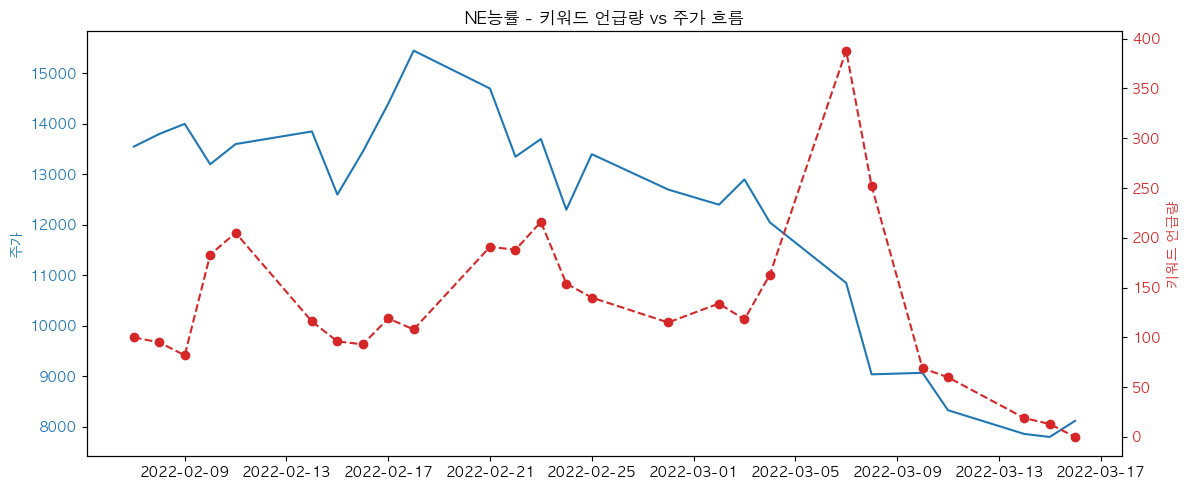

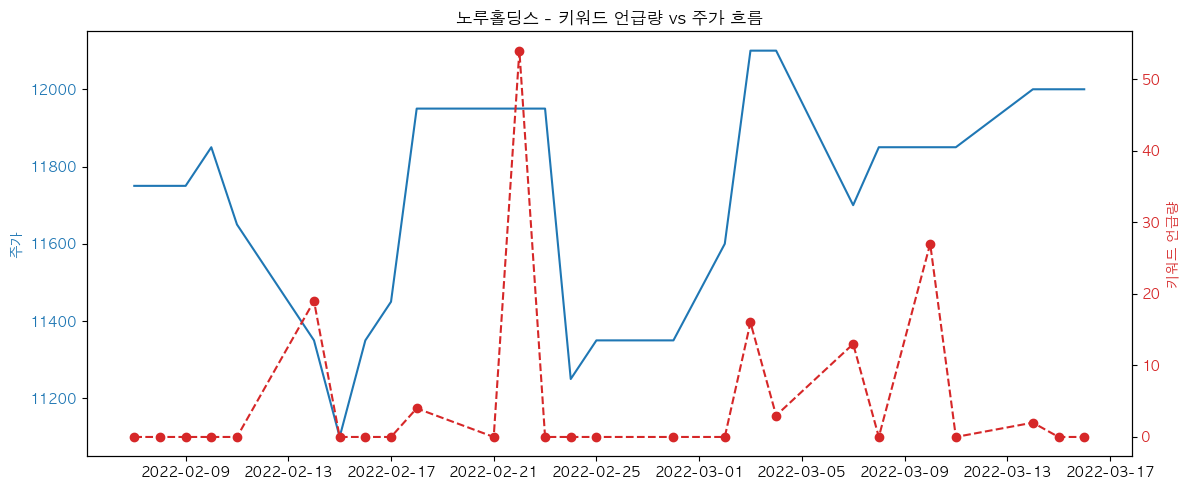

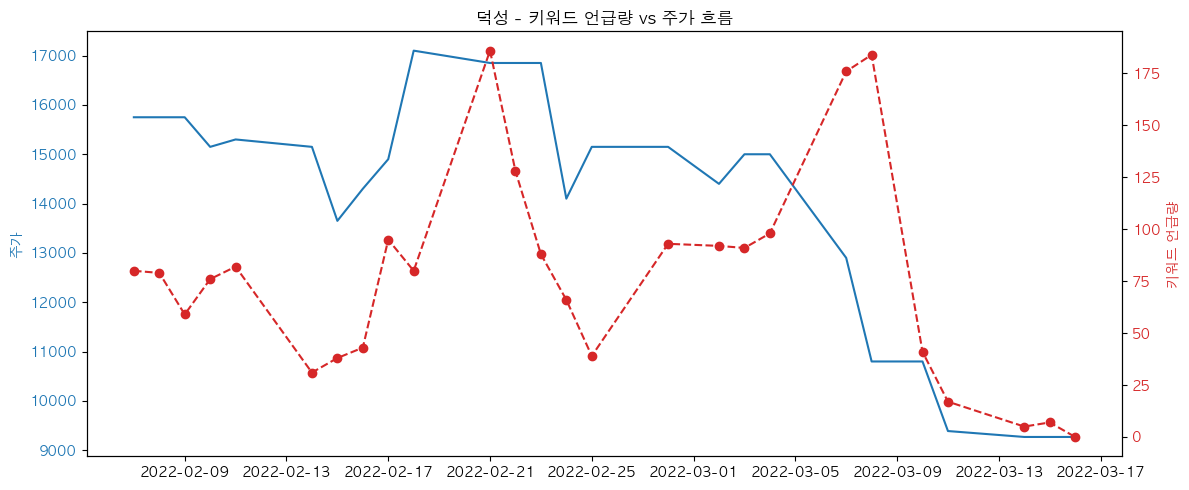

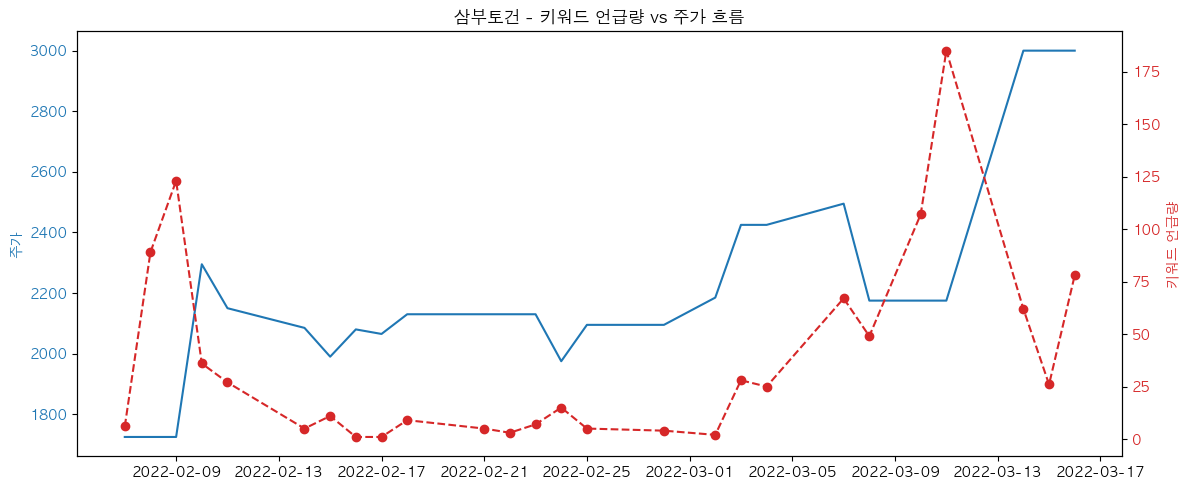

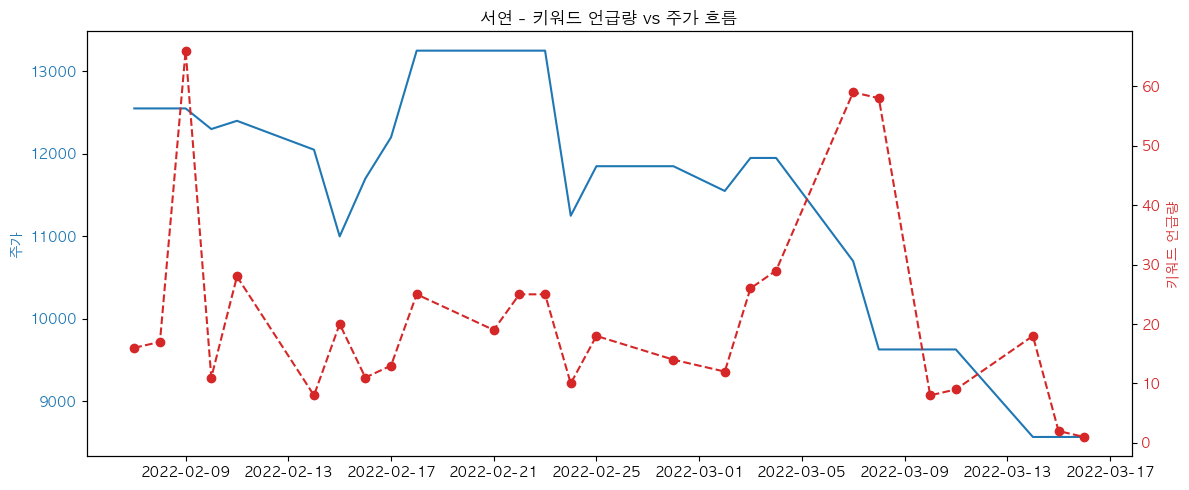

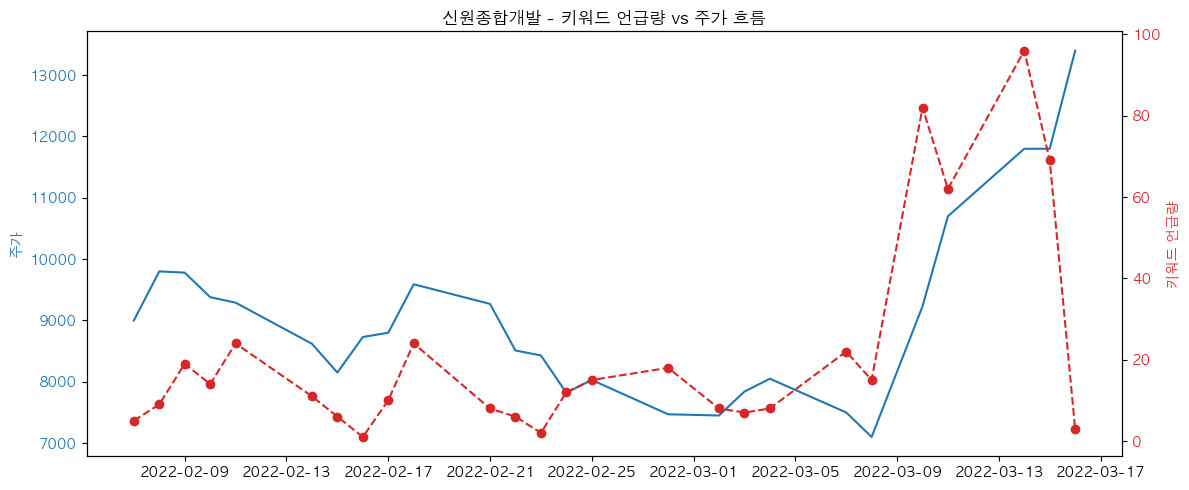

In [44]:
generator = BuzzChartGenerator(final_df, yoon_df, DATA_DIR)

for stock in final_df["종목명"].unique():
    if stock not in yoon_df["종목명"].values:
        continue
    buzz_df = generator.extract_keywords_by_date(
        stock, start_date=FIXED_START, end_date=FIXED_END
    )
    merged_df = generator.merge_with_price(
        stock, buzz_df, start_date=FIXED_START, end_date=FIXED_END
    )
    generator.plot_buzz_chart(merged_df, stock)

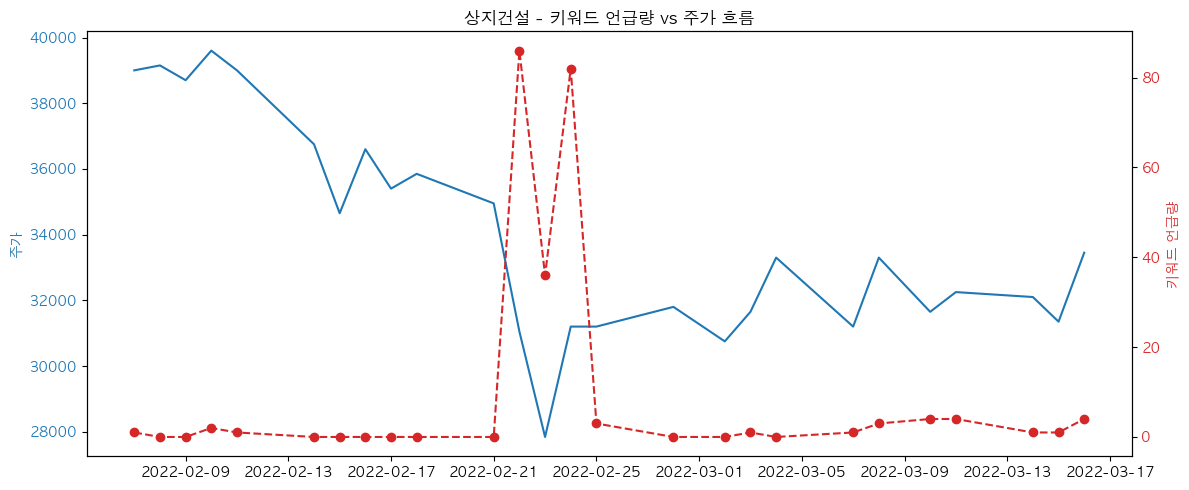

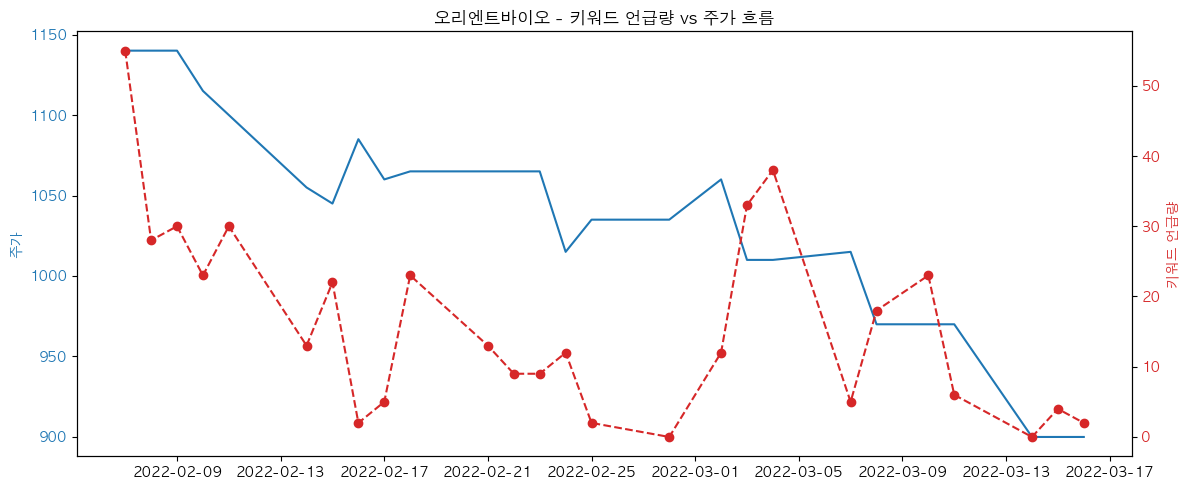

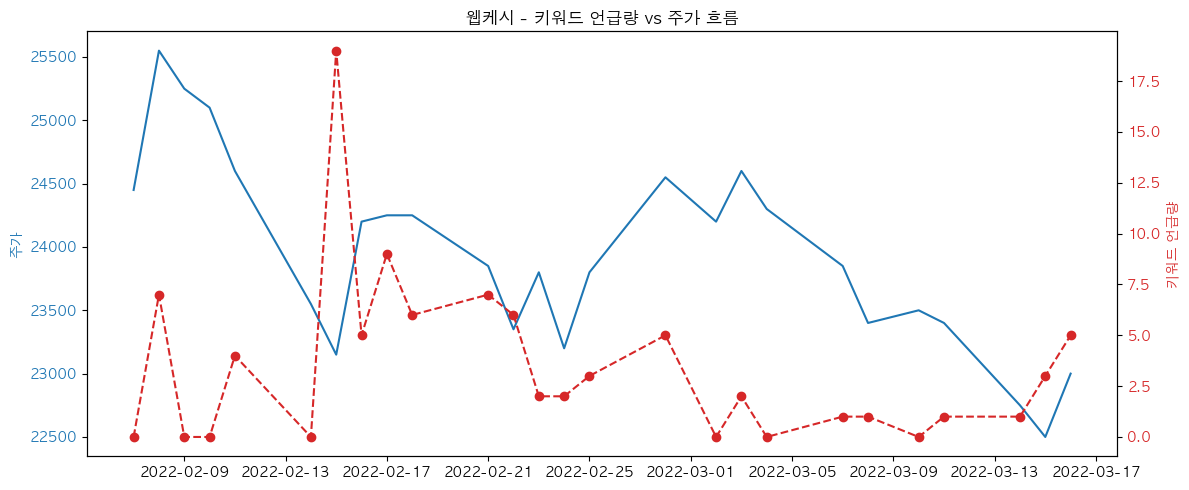

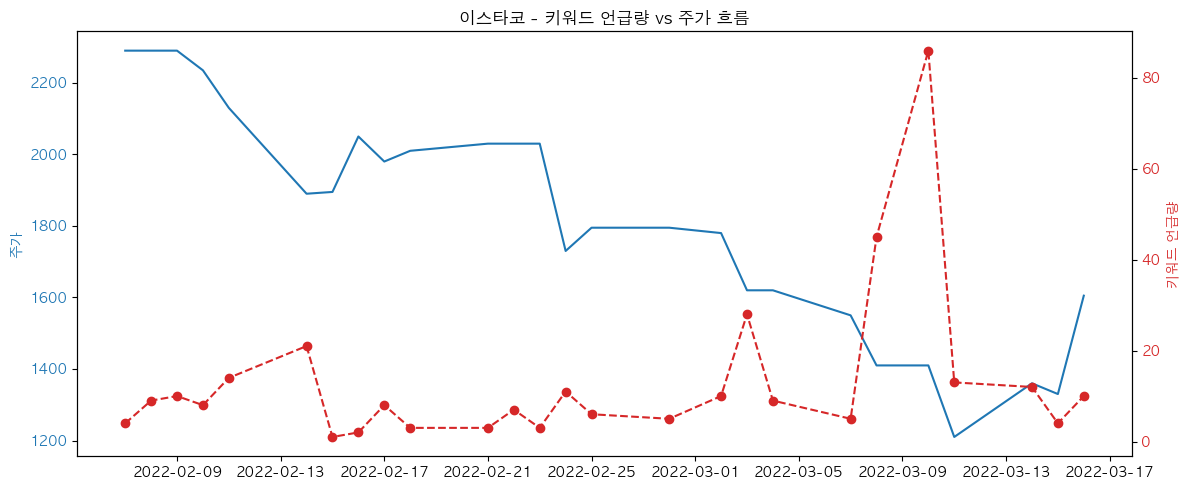

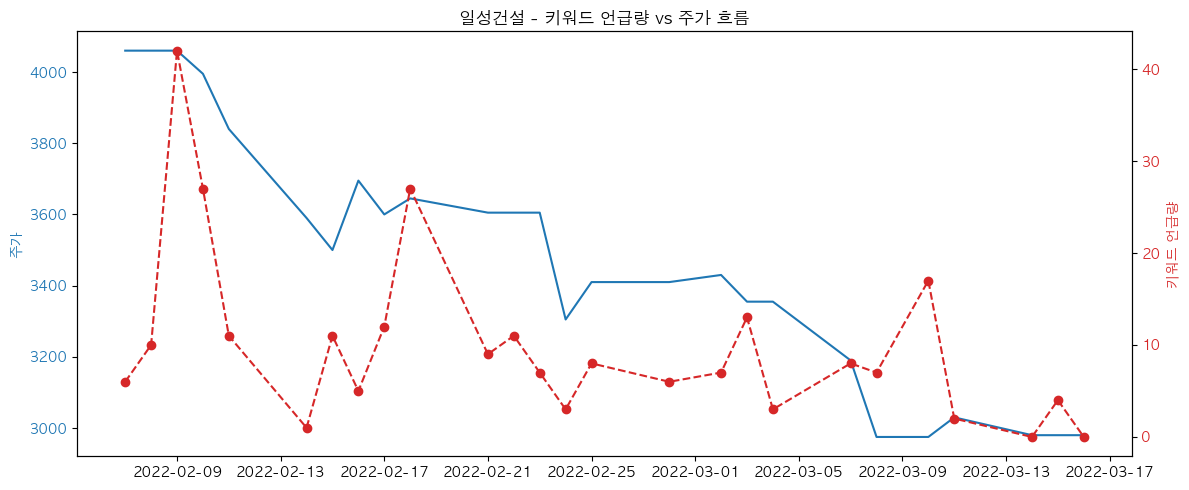

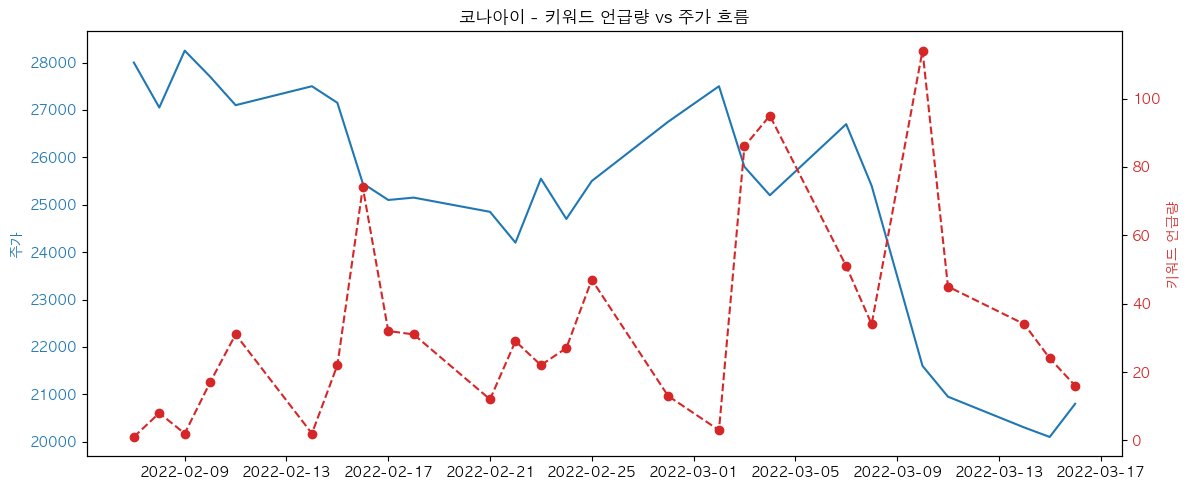

In [45]:
generator = BuzzChartGenerator(final_df, lee_df, DATA_DIR)

for stock in final_df["종목명"].unique():
    if stock not in lee_df["종목명"].values:
        continue
    buzz_df = generator.extract_keywords_by_date(
        stock, start_date=FIXED_START, end_date=FIXED_END
    )
    merged_df = generator.merge_with_price(
        stock, buzz_df, start_date=FIXED_START, end_date=FIXED_END
    )
    generator.plot_buzz_chart(merged_df, stock)